# Projekt LLM 25L - Klasyfikacja tekstu na wybranym zbiorze danych poprzez dostrojenie modelu klasy tylko-koder

## Adam Kraś 325177

In [3]:
import torch
import torch.nn as nn
import datasets
import evaluate
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
!nvidia-smi

Fri May 30 23:41:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   36C    P8              2W /   55W |       3MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Wczytanie wybranego zbioru danych
dataset = datasets.load_dataset("community-datasets/yahoo_answers_topics")

In [5]:
dataset["train"][420]  # Wyświetlenie przykładu z zestawu danych

{'id': 420,
 'topic': 4,
 'question_title': 'Who invented the mouse?',
 'question_content': '',
 'best_answer': 'According to the bible, it was God.\\nAccording to Darwin, it was natural evolution.\\nMany others will convince you that it was Steve Jobs and Apple.\\n\\nThe answer, according to http://www.superkids.com/aweb/pages/features/mouse/mouse.html, is Doug Engelbart.\\n\\n(which I found via this Yahoo! Search http://myweb2.search.yahoo.com/search?p=who+invented+the+mouse.)'}

Computers & Internet: 140000
Sports: 140000
Health: 140000
Business & Finance: 140000
Science & Mathematics: 140000
Entertainment & Music: 140000
Education & Reference: 140000
Family & Relationships: 140000
Politics & Government: 140000
Society & Culture: 140000


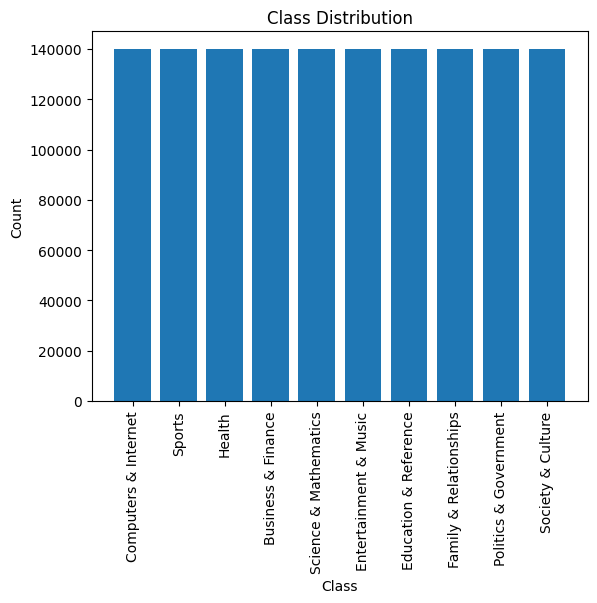

In [6]:
labels = dataset["train"]["topic"]
label_counts = Counter(labels)
label_names = dataset["train"].features["topic"].names

for label_id, count in label_counts.items():
    print(f"{label_names[label_id]}: {count}")

labels_text = [label_names[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.bar(labels_text, counts)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [7]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Porównanie rozmiarów zbiorów danych treningowego i testowego
print(f"Dataset size: {len(train_dataset) + len(test_dataset)}")
print(f"Train dataset size: {len(train_dataset) / (len(train_dataset) + len(test_dataset)) * 100:.2f}%")
print(f"Test dataset size: {len(test_dataset) / (len(train_dataset) + len(test_dataset)) * 100:.2f}%")

Dataset size: 1460000
Train dataset size: 95.89%
Test dataset size: 4.11%


Jak widzimy, stosunek rozmiarów zbioru treningowego i testowego są dalekie od idealnych. Ponadto, nie ma zbioru walidaycjnego. Zróbmy coś z tym.

Jednakże, przed podzieleniem zbioru danych na nowo, przetestujemy różne zredukowane jego rozmiary, gdyż prawie 1,5 miliona elementów to zdecydowanie więcej niż wynosi optymalny pod względem obliczeniowym i efektywnościowym rozmiar zbioru do klasyfikacji 10-klasowej dla wybranego przeze mnie modelu.

In [ ]:
# dataset_size = 500000

# reduced_train = train_dataset.train_test_split(
#     train_size=dataset_size,
#     test_size=dataset_size // 5,
#     stratify_by_column="topic",
#     shuffle=True,
#     seed=42
# )["train"]

# train_dataset = reduced_train

Potwierdźmy czy balans klas został zachowany po zmniejszeniu rozmiaru zbioru danych

Society & Culture: 50000
Education & Reference: 50000
Entertainment & Music: 50000
Sports: 50000
Health: 50000
Science & Mathematics: 50000
Family & Relationships: 50000
Business & Finance: 50000
Computers & Internet: 50000
Politics & Government: 50000


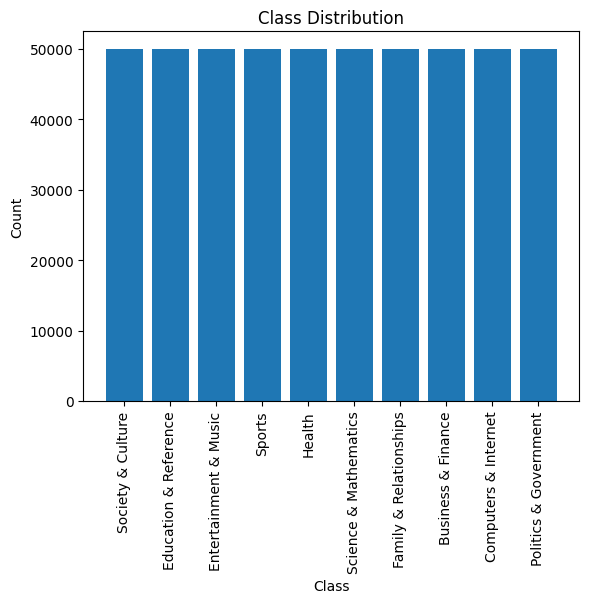

In [9]:
labels = train_dataset["topic"]
label_counts = Counter(labels)
label_names = train_dataset.features["topic"].names

for label_id, count in label_counts.items():
    print(f"{label_names[label_id]}: {count}")

labels_text = [label_names[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.bar(labels_text, counts)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [8]:
full_split = train_dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = full_split["test"].train_test_split(test_size=0.5, seed=42)

train_dataset = full_split["train"]
val_dataset = val_test_split["train"]
test_dataset = val_test_split["test"]

# Sprawdzenie rozmiarów zbiorów danych po podziale
print(f"Dataset size: {len(train_dataset) + len(test_dataset) + len(val_dataset)}")
print(f"Train dataset size: {len(train_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")
print(f"Test dataset size: {len(test_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")
print(f"Validation dataset size: {len(val_dataset) / (len(train_dataset) + len(test_dataset) + len(val_dataset)) * 100:.2f}%")

Dataset size: 1400000
Train dataset size: 80.00%
Test dataset size: 10.00%
Validation dataset size: 10.00%


In [9]:
# Przygotowanie modelu
# q_config = BitsAndBytesConfig(load_in_8bit=True)

base_model_id = "google-bert/bert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_id,
    num_labels=10,
    id2label={i: label_names[i] for i in range(10)},
    label2id={label_names[i]: i for i in range(10)},
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
print(model)

print(f"\n\nZajętość pamięci przez model: {model.get_memory_footprint() / 1024**3:0.3f}GB")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model.pad_token_id = tokenizer.pad_token_id
print(f"Rozmiar słownika: {tokenizer.vocab_size}")

Rozmiar słownika: 30522


In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [22]:
# # Sprawdzenie długości tokenów w zbiorze danych
# print(f"Maksymalna obsługiwana długość: {tokenizer.model_max_length}")

# def get_token_length(example):
#     text = example["question_title"] + " " + example["question_content"]
#     return len(tokenizer.encode(text, truncation=False))

# lengths = [get_token_length(example) for example in train_dataset]

# import numpy as np

# print("Średnia długość:", np.mean(lengths))
# print("Mediana:", np.median(lengths))
# print("Max:", np.max(lengths))
# print("Powyżej limitu:", sum(l > tokenizer.model_max_length for l in lengths))

Jak widzimy, tylko jeden przykład w całym zbiorze danych przekracza maksymalną obsługiwaną przez model długość tekstu. W takim przypadku najprostszym rozwiązaniem będzie ustawienie flagi truncation na True w tokenizatorze.

In [13]:
# Tokenizacja danych
def preprocess(example):
    texts = [title + " " + content for title, content in zip(example["question_title"], example["question_content"])]
    return tokenizer(texts, truncation=True, padding="max_length", max_length=128)

tokenized_train = train_dataset.map(preprocess, batched=True)
tokenized_val = val_dataset.map(preprocess, batched=True)
tokenized_test = test_dataset.map(preprocess, batched=True)

print("Tokenizacja zakończona")

Map:   0%|          | 0/1120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/140000 [00:00<?, ? examples/s]

Map:   0%|          | 0/140000 [00:00<?, ? examples/s]

Tokenizacja zakończona


In [14]:
# Dodanie kolumny 'labels' do tokenizowanych zbiorów danych
def add_labels(example):
    example["labels"] = example["topic"]
    return example

tokenized_train = tokenized_train.map(add_labels, batched=True)
tokenized_val = tokenized_val.map(add_labels, batched=True)
tokenized_test = tokenized_test.map(add_labels, batched=True)
print("Dodawanie etykiet zakończone")

Map:   0%|          | 0/1120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/140000 [00:00<?, ? examples/s]

Map:   0%|          | 0/140000 [00:00<?, ? examples/s]

Dodawanie etykiet zakończone


In [15]:
tokenized_train[0].keys()  # Sprawdzenie kluczy w tokenizowanym zbiorze danych

dict_keys(['id', 'topic', 'question_title', 'question_content', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [16]:
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    gradient_accumulation_steps=2,
)

In [17]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

Przed treningiem zamrozimy również wszystkie parametry modelu nie odpowiadające za klasyfikację. W ten sposób trening będzie szybszy i skorzystamy z "czystego" dotrenowywania modelu bez zmieniania go w całości. Warstwy poolingowe również zostały odmrożone. Sumarycznie zatem dotrenujemy 4 ostatnie warstwy modelu.

In [18]:
# for name, param in model.base_model.named_parameters():
#     param.requires_grad = False if "pooler" not in name else True

# full fine-tuning
for param in model.base_model.parameters():
    param.requires_grad = True

# for name, param in model.base_model.named_parameters():
#     if any(f"encoder.layer.{i}." in name for i in range(0, 4)):
#         param.requires_grad = False

In [19]:
# model = PhiClassifier(base_model_id, num_labels=10).to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

In [20]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kraskoa (kraskoa-politechnika-warszawska) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.801100,0.730793,0.759107
2,0.688800,0.724618,0.761564
3,0.620200,0.738295,0.760743
4,0.554400,0.769038,0.756957


TrainOutput(global_step=35000, training_loss=0.6661343610491072, metrics={'train_runtime': 23394.6744, 'train_samples_per_second': 478.741, 'train_steps_per_second': 3.74, 'total_flos': 2.9470554882048e+17, 'train_loss': 0.6661343610491072, 'epoch': 4.0})

Teraz sprawdxmy osiągniętą dokładność na zbiorze testowym.

In [21]:
metrics = trainer.evaluate(tokenized_test)
print(f"Test accuracy: {metrics['eval_accuracy']:.4f}")

Test accuracy: 0.7620


In [22]:
trainer.save_model("bert-full-0frozen")

In [7]:
model = AutoModelForSequenceClassification.from_pretrained("bert-full-0frozen")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
# confusion matrix
# preds = trainer.predict(tokenized_test)
preds = model.predict(tokenized_test)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax, cmap="Blues")
plt.title("Confusion matrix")
plt.show()

AttributeError: 'BertForSequenceClassification' object has no attribute 'predict'